In [83]:
from pandas_datareader import data as pdr
import numpy as np
from numpy import arange
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as rcv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import mixture as mix
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from IPython import get_ipython
import datetime
import yfinance as yf
import csv

In [15]:
n = 3 # DAYS IN THE FUTURE TO PREDICT


df = pdr.DataReader('ETH-USD',data_source='yahoo' ,start='2020-01-01',end=datetime.date.today())
df = df[['Open']]#,'High','Low','Close','Volume']] 

# YF FEATURES
yf_features = ['SPY','VXX','BTC-USD','QQQ','XLP','TSLA','GLD','TBT','DOGE-USD','LTC-USD','XRP-USD','ADA-USD','LTPZ',]
for val in yf_features:
    df = df.join(pdr.DataReader(val,data_source='yahoo',start='2020-01-01',end=datetime.date.today())[['Close','Volume']].rename(columns={"Close":val+"Close", "Volume":val+"Volume"}))
df = df[:-1]

# FRED FEATURES
fred_features = ['GS10', 'CPIAUCSL']
for val in fred_features:
    df = df.join(pdr.get_data_fred(val,start='2020-01-01'))

df.insert(0,'Future',df['Open'].shift(-n))
# df['Future'] = df['Open'].shift(-1)
df

,Future,Open,SPYClose,SPYVolume,VXXClose,VXXVolume,BTC-USDClose,BTC-USDVolume,QQQClose,QQQVolume,...,LTC-USDClose,LTC-USDVolume,XRP-USDClose,XRP-USDVolume,ADA-USDClose,ADA-USDVolume,LTPZClose,LTPZVolume,GS10,CPIAUCSL
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,134.168518,129.630661,NaN,NaN,NaN,NaN,7200.174316,18565664997,NaN,NaN,...,42.017719,2782992323,0.192667,1041134003,0.033458,22948374,NaN,NaN,1.76,258.687
2020-01-02,135.072098,130.820038,324.869995,59151200.0,58.040001,7078100.0,6985.470215,20802083465,216.160004,30969400.0,...,39.823013,2759827139,0.188043,1085351426,0.032751,20843934,73.199997,136900.0,NaN,NaN
2020-01-03,136.305542,127.411263,322.410004,77709700.0,61.160000,12039150.0,7344.884277,28111481032,214.179993,27518900.0,...,42.415573,3260961326,0.193521,1270017043,0.034180,30162644,74.070000,113200.0,NaN,NaN
2020-01-04,144.311996,134.168518,NaN,NaN,NaN,NaN,7410.656738,18444271275,NaN,NaN,...,43.326607,2843192897,0.194355,999331594,0.034595,29535781,NaN,NaN,NaN,NaN
2020-01-05,143.487823,135.072098,NaN,NaN,NaN,NaN,7411.317383,19725074095,NaN,NaN,...,43.553207,3017148033,0.195537,1168067557,0.034721,21479178,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-11,3248.648682,3082.990967,469.750000,74303100.0,17.820000,52551300.0,42735.855469,26327648900,385.820007,68295700.0,...,131.544983,834900749,0.770554,1897366203,1.185110,1089929557,87.180000,343600.0,NaN,NaN
2022-01-12,3309.844238,3238.449951,471.019989,67605400.0,17.629999,43270200.0,43949.101562,33499938689,387.350006,54576400.0,...,141.737198,881585292,0.799548,1976047994,1.304535,1651269250,85.639999,348400.0,NaN,NaN
2022-01-13,NaN,3372.104980,464.529999,91173100.0,18.740000,59111100.0,42591.570312,47691135082,377.660004,77994000.0,...,136.636520,886433982,0.768328,1578656460,1.233161,2022506483,85.989998,133200.0,NaN,NaN


In [16]:
df2 = df # backup

## Lasso and Ridge Regression

In [17]:
# Fills in NaN values for LASSO regression
df2 = df2.fillna(method ='ffill')[1:]
df2 = df2.values

X, y = df2[:, 1:], df2[:, 0]

# define model evaluation method via repeated K-Fold Cross Validation
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

Below we try both Ridge and Lasso regressions in order to make our predictions. Both estimators shrink the estimator to zero, however, Ridge penalizes large squared values of the coefficients. Then we go ahead and minimize the penalized sum of squared residuals:

$$\min\{\sum_{i=1}^n(Y_i - X_i^{'}b)^2 + \lambda_{Ridge}\sum_{j=1}^{k}b_j^2\}$$

Similarly, Lasso shrinks the estimate towards zero by penalizing absolute values of the coefficients as shown below:

$$\min\{\sum_{i=1}^n(Y_i - X_i^{'}b)^2 + \lambda_{Lasso}\sum_{j=1}^{k}|b_j|\}$$

In both cases we $10$-fold cross validation in order to determine the $\lambda_{Ridge}$ and $\lambda_{Lasso}$ which yield the lowest MSPE$(\lambda_{Ridge})$ and MSPE$(\lambda_{Lasso})$ respectively.

It is worth noting that Lasso looks very similar to Ridge, but turns out to have one very special property: Lasso
tends to set many the $\hat{\beta}$’s exactly to $0$. Ridge shrinks them relative to OLS, but doesn’t shrink
them all the way to zero.

This feature means that Lasso can work especially well when in reality many of the predictors are irrelevant (but we don’t know which ones).  

DUBIOUS: This indicates a reason that Lasso does in fact provides better estimates in our goal of estimating ETH-USD's open price.



In [18]:
# define model
model = LassoCV(alphas =arange(0.01, 20, 0.01), cv = cv, n_jobs = -1, tol = 1)
model2 = make_pipeline(StandardScaler(with_mean=False), RidgeCV(alphas =arange(0.01, 20, 0.01), cv = cv))

# fit model
model.fit(X, y)
model2.fit(X, y)

# summarize chosen configuration
print('alpha: %f' % model.alpha_)
# Not sure how to print this alpha
print('alpha: %f' % model2[1].alpha_)

alpha: 0.010000
alpha: 0.480000


In [29]:
# Price prediction n days from now using LASSO CV
print("Lasso prediction: " , model.predict([df2[-1][1:]])[0])

Lasso prediction:  3269.5540628013773


In [30]:
# Price prediction n days from now using RIDGE CV
print("Ridge prediction: " , model2.predict([df2[-1][1:]])[0])

Ridge prediction:  3359.000373966601


In [31]:
# Today's price prediction from n days ago using LASSO CV
print("Lasso prediction: " , model.predict([df2[-n-1][1:]])[0])
print("Percent error: " , 100*(df2[-n-1][0] - model.predict([df2[-n-1][1:]])[0])/df2[-n-1][0] , "%")

Lasso prediction:  3231.387561873895
Percent error:  2.3704038848697153 %


In [32]:
# Today's price prediction from n days ago using Ridge CV
print("Ridge prediction: " , model2.predict([df2[-1][1:]])[0])
print("Percent error: " , 100*(df2[-n-1][0] - model2.predict([df2[-n-1][1:]])[0])/df2[-n-1][0] , "%")

Ridge prediction:  3359.000373966601
Percent error:  0.8097478305924849 %


## ARIMA

ADF statistic:  -1.2586660478184757
p-value:  0.6478642497248954


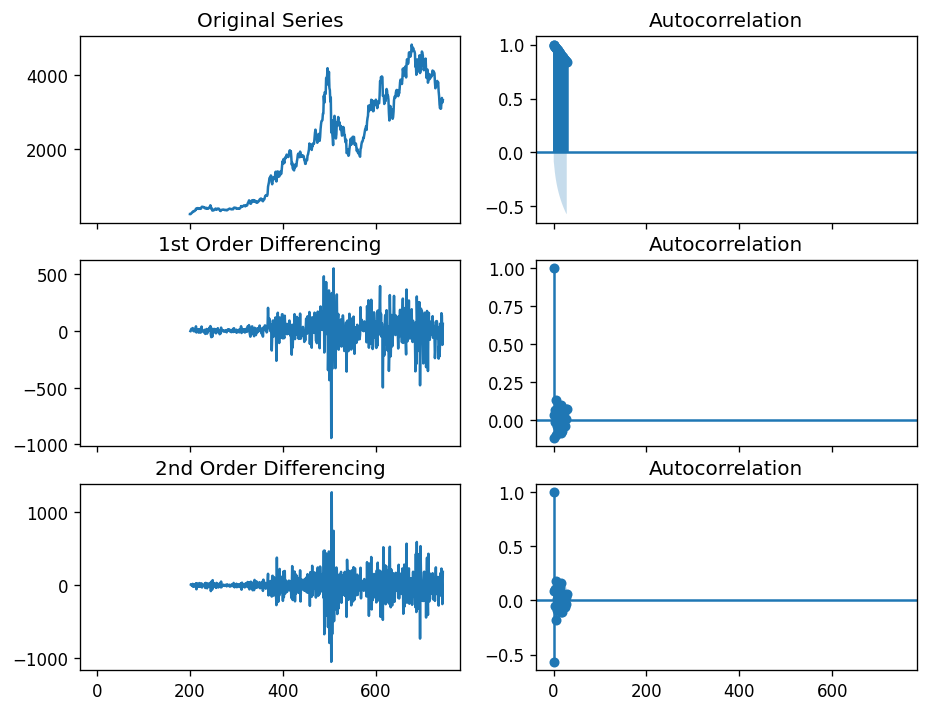

In [120]:
# Finding order of differencing
series = pd.DataFrame(df2[:,1], columns=['vals'])[200:]
print("ADF statistic: " , adfuller(series)[0])
print("p-value: " , adfuller(series)[1])

# markdown this later: non-stationary, so must apply differencing

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

series
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(series.vals); axes[0, 0].set_title('Original Series')
plot_acf(series.vals, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series.vals.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.vals.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(series.vals.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.vals.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## Regime Detection

Idea: regime detection based both on post-panny sp500 data and complete since-2000 data (perhaps volatility conditions changed).

In [8]:
sp2000 = pdr.DataReader('SPY',data_source='yahoo' ,start='2000-01-01',end=datetime.date.today())[['Close']].dropna()
sp2020 = pdr.DataReader('SPY',data_source='yahoo' ,start='2020-01-01',end=datetime.date.today())[['Close']].dropna()

In [9]:
# add returns column
sp2000['Returns'] = np.log(sp2000['Close']/sp2000['Close'].shift(1))
sp2020['Returns'] = np.log(sp2020['Close']/sp2020['Close'].shift(1))

In [10]:
# delete?
steps = [('scaler',StandardScaler()),
         ('lasso',Lasso())]        

pipeline = Pipeline(steps)


parameters = {'lasso__alpha':np.arange(0.0001,10,.0001),
              'lasso__max_iter':np.random.uniform(100,100000,4)}


reg = rcv(pipeline, parameters,cv=5)